# ELFI demo v0.7.5

Load some packages:

In [1]:
import elfi
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as ss
from functools import partial
import graphviz

Define generative model in the format that ``elfi`` requires (``batch_size * n_obs``). 
The model here is $x_i \stackrel{iid}{\thicksim} \text{Poisson}(\mu), \quad i = 1, \ldots, n_\text{obs}$

In [2]:
def poisson(mu, n_obs=1, batch_size=1, random_state=None):
    """Return n_obs independent draws from the poisson-distribution."""
    mu = np.repeat(mu, repeats=n_obs).reshape(batch_size, -1)
    x = ss.poisson.rvs(mu=mu, random_state=random_state).reshape(batch_size, -1)
    
    return x

Define summary statistics (here sum of the observations $\sum_{i=1}^{n_\text{obs}} x_i$) for the data
in the format that ``elfi`` requires ``(batch_size * N)``

In [3]:
def summary_stats(x):
    """Return summary statistics for data x"""
    x = np.atleast_2d(x)
    s = np.sum(x, axis=1, keepdims=True)
    
    return s

Define a new ``elfi``-graph

In [4]:
# New model instance
m = elfi.ElfiModel()

# Generate an simulated "observed" dataset
# Fix true parameter value
mu_true = 5.0
# Fix seed for reproducibility
seed_obs = 10
random_state = np.random.RandomState(seed_obs)
# Generate dataset from the generative model
# number of iid observations
n_obs = 10
x_obs = poisson(mu_true, n_obs=n_obs, random_state=random_state)


In [5]:
x_obs

array([[4, 3, 3, 8, 7, 5, 2, 7, 4, 7]])

Use ``partial`` to fix ``n_obs`` in the generative model.

In [6]:
gen_model = partial(poisson, n_obs=n_obs)

Define the prior node. Custom `scipy.stats`-format distributions work and some are available as keywords.

In [7]:
mu = elfi.Prior('exponential', 0, 10, model=m)

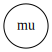

In [8]:
elfi.draw(m)

Generate the ``elfi.Simulator``-node from the model source

In [9]:
elfi.Simulator(gen_model, mu, observed=x_obs, name='poisson')

Simulator(name='poisson')

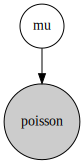

In [10]:
elfi.draw(m)

Add the summary statistic node to the ``elfi-model``

In [11]:
elfi.Summary(summary_stats, m['poisson'], name='poisson_ss')

Summary(name='poisson_ss')

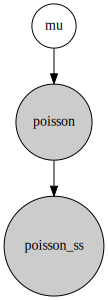

In [12]:
elfi.draw(m)

Add the distance node to ``elfi-model``

In [13]:
elfi.Distance('euclidean', m['poisson_ss'], name='d')

Distance(name='d')

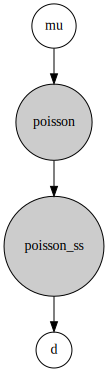

In [14]:
elfi.draw(m)

Generate rejection ABC instance 

In [15]:
rejABC = elfi.Rejection(m['d'], batch_size=100)

Run the instance until requirement ``n_samples=1000`` is fulfilled

In [16]:
rejRes = rejABC.sample(n_samples=1000)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [17]:
print(rejRes)

Method: Rejection
Number of samples: 1000
Number of simulations: 100000
Threshold: 1
Sample means: mu: 5.04



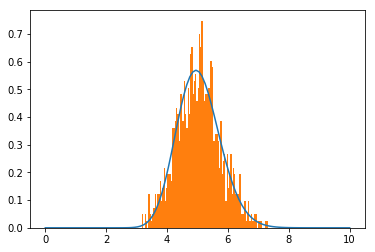

In [18]:
mu_plot = np.linspace(0,10,100)
post_shape = 1 + np.sum(x_obs)
post_scale = 10 / (n_obs * 10 + 1)
gamma_posterior = ss.gamma.pdf(mu_plot, a=post_shape, scale=post_scale)
plt.plot(mu_plot, gamma_posterior)
plt.hist(rejRes.samples['mu'], density=True, bins=100)
plt.show()

In [19]:
rejRes = rejABC.sample(n_samples=5000)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


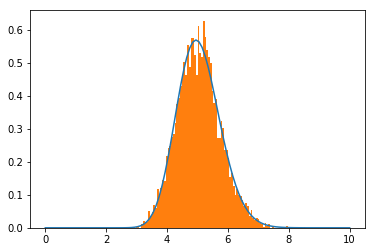

In [20]:
plt.plot(mu_plot, gamma_posterior)
plt.hist(rejRes.samples['mu'], density=True, bins=100)
plt.show()

# Implementing new methods in ELFI

Implementing a new method ``CustomMethod`` requires at minimum following methods

In [22]:
from elfi.methods.parameter_inference import ParameterInference

class CustomMethod(ParameterInference):

    def __init__(self, model, output_names, **kwargs):
        super(CustomMethod, self).__init__(model, output_names, **kwargs)

    def set_objective(self):
        # Request 3 batches to be generated
        self.objective['n_batches'] = 3

    def extract_result(self):
        return self.state

Method doesn't do anything interesting. Note: ``infer`` sets the objective, starts the iterate loop until the inference is finished and extracts the result.

In [23]:
custom_method = CustomMethod(m,['d'])
custom_method.infer()

Progress: |██████████████████████████████████████████████████| 100.0% Complete


{'n_batches': 3, 'n_sim': 3}

In [24]:
import numpy as np

from elfi.methods.parameter_inference import ParameterInference
from elfi.methods.results import Sample


class CustomMethod(ParameterInference):
    def __init__(self, model, discrepancy_name, threshold, **kwargs):
       # Create a name list of nodes whose outputs we wish to receive
       output_names = [discrepancy_name] + model.parameter_names
       super(CustomMethod, self).__init__(model, output_names, **kwargs)

       self.threshold = threshold
       self.discrepancy_name = discrepancy_name

       # Prepare lists to push the filtered outputs into
       self.state['filtered_outputs'] = {name: [] for name in output_names}

    def set_objective(self, n_sim):
       self.objective['n_sim'] = n_sim

    def update(self, batch, batch_index):
       super(CustomMethod, self).update(batch, batch_index)

       # Make a filter mask (logical numpy array) from the distance array
       filter_mask = batch[self.discrepancy_name] <= self.threshold

       # Append the filtered parameters to their lists
       for name in self.output_names:
           values = batch[name]
           self.state['filtered_outputs'][name].append(values[filter_mask])

    def extract_result(self):
       filtered_outputs = self.state['filtered_outputs']
       outputs = {name: np.concatenate(filtered_outputs[name]) for name in self.output_names}

       return Sample(
           method_name='CustomMethod',
           outputs=outputs,
           parameter_names=self.parameter_names,
           discrepancy_name=self.discrepancy_name,
           n_sim=self.state['n_sim'],
           threshold=self.threshold
           ) 

In [25]:
custom_method = CustomMethod(m,'d',threshold=5)
custom_method.infer(n_sim=4000)

Progress: |██████--------------------------------------------| 12.6% Complete

Progress: |█████████-----------------------------------------| 19.2% Complete

Progress: |███████████████-----------------------------------| 31.9% Complete

Progress: |█████████████████████-----------------------------| 43.5% Complete

Progress: |███████████████████████████-----------------------| 55.9% Complete

Progress: |██████████████████████████████████----------------| 68.5% Complete

Progress: |█████████████████████████████████████-------------| 74.7% Complete

Progress: |███████████████████████████████████████████-------| 87.2% Complete

Progress: |██████████████████████████████████████████████----| 93.1% Complete

Progress: |█████████████████████████████████████████████████-| 99.3% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete


Method: CustomMethod
Number of samples: 239
Number of simulations: 4000
Threshold: 5
Sample means: mu: 5.08

# Implementation of synthetic likelihood

In [26]:
import elfi.examples.ma2 as ma2
from elfi.methods.parameter_inference import ParameterInference
import scipy.stats as ss
from scipy.spatial.distance import mahalanobis
from elfi.methods.utils import (GMDistribution, ModelPrior, arr2d_to_batch,
                                batch_to_arr2d, ceil_to_batch_size)
from elfi.methods.results import Sample
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class psBIL(ParameterInference):
    """Class for Parametric Bayesian Indirect Likelihood (pBIL).

    References
    ----------
    Drovandi, CC and Pettitt, AN and Lee, A  (2015). Bayesian Indirect
    Inference Using a Parametric Auxiliary Model.
    Statistical Science 30(1):72−95, 2015.

    """

    def __init__(self, model, summary_names=None, chain_length=2000, chains=4, burn_in=1000, sigma_proposals=None, **kwargs):
        """Initialize pBIL object.

        Parameters
        ----------
        model : ElfiModel or NodeReference
        summary_names : list, optional
            Summaries from the model to be included in the auxiliary
            likelihood estimation
        chain_length : int, optional
            Length of each MCMC chain
        chains : int, optional
            Number of MCMC chains
        burn_in : int, optional
            Number of elements to be discarded from each chain
        kwargs:
            See InferenceMethod

        """
        output_names = summary_names + model.parameter_names
        super(psBIL, self).__init__(model, output_names, **kwargs)

        # n_samples = 10000 # chain_length * chains
        self.n_samples = chain_length * chains
        self.state['logposterior'] = np.empty(self.n_samples)
        self.state['mahalanobis'] = np.empty(self.n_samples)
        self.summary_names = summary_names
        self.observed = self._get_observed_summary_values()
        self.prior_state = dict()
        self.chain_length = chain_length
        self.chains = chains
        self.burn_in = burn_in
        self._prior = ModelPrior(self.model)
        self.sigma_proposals = sigma_proposals
        for parameter_name in self.parameter_names:
            self.state[parameter_name] = np.empty(self.n_samples)

    def _get_observed_summary_values(self):
        """Get the observed values for summary statistics.

        Returns
        -------
        np.ndarray

        """
        observed_ss = [self.model[summary_name].observed for summary_name in self.summary_names]
        observed_ss = np.column_stack(observed_ss)
        return observed_ss

    def set_objective(self):
        """Set the objective for the inference."""
        self.objective['n_batches'] = self.n_samples
        self.objective['n_sim'] = self.n_samples * self.batch_size

    def extract_result(self):
        """Extract the result from the current state.

        Returns
        -------
        result : Sample

        """
        if self.state['logposterior'] is None:
            raise ValueError('Nothing to extract')

        # Take out the correct number of samples
        outputs = dict()
        index_array = np.array(range(self.burn_in, self.chain_length))
        burn_in_mask = index_array
        for i in range(self.chains-1):
            burn_in_mask = np.append(burn_in_mask, index_array + self.chain_length * (i + 1))

        binary_array = np.zeros(burn_in_mask[-1]+1)
        binary_array[burn_in_mask] = 1

        for p in self.parameter_names:
            outputs[p] = self.state[p][burn_in_mask]

        return Sample(outputs=outputs, **self._extract_result_kwargs())

    def update(self, batch, batch_index):
        """Update the state with a new batch."""
        super(psBIL, self).update(batch, batch_index)

        params = np.column_stack(tuple([batch[p] for p in self.summary_names]))
        sample_mean = np.mean(params, axis=0).flatten()
        sample_cov = np.cov(params, rowvar=False)

        self._evaluate_auxiliary_model_logpdf(batch_index, sample_mean, sample_cov)
        self._evaluate_mahalanobis(batch_index, sample_mean, sample_cov)
        tmp = {p: self.prop_state[0, i] for i, p in enumerate(self.parameter_names)}
        for p in self.parameter_names:
            self.state[p][batch_index] = tmp[p]

        # if batch_index > 0:
        if not self.start_new_chain:
            l_ratio = self._get_likelihood_ratio(batch_index)
            prob = np.minimum(1.0, l_ratio)
            u = ss.uniform.rvs()
            if u > prob:
                for key in self.state:
                    if type(self.state[key]) is not int:
                        self.state[key][batch_index] = self.state[key][batch_index-1]

    def _evaluate_auxiliary_model_logpdf(self, batch_index, sample_mean, sample_cov, model="normal"):
        """Evaluate auxiliary model log-likelihood."""
        if model == "normal":
            self.state['logposterior'][batch_index] = ss.multivariate_normal.logpdf(self.observed, mean=sample_mean, cov=sample_cov)

    def _evaluate_mahalanobis(self, batch_index, sample_mean, sample_cov):
        """Evaluate Mahalanobis distance at the current state."""
        self.state['mahalanobis'][batch_index] = mahalanobis(self.observed, sample_mean, np.linalg.inv(sample_cov))

    def _get_likelihood_ratio(self, batch_index):
        """Get likelihood ratio between two consecutive steps."""
        current = self.state['logposterior'][batch_index]
        previous = self.state['logposterior'][batch_index-1]
        return np.exp(current - previous)

    def prepare_new_batch(self, batch_index):
        """Prepare parameter values for a new batch.

        Parameters
        ----------
        batch_index : int
            next batch_index to be submitted

        Returns
        -------
        batch : dict or None
            Keys should match to node names in the model.
            These values will override any
            default values or operations in those nodes.

        """
        self.start_new_chain = (batch_index % self.chain_length) == 0
        if self.start_new_chain:
            state = self.model.generate(1)

        for p in self.parameter_names:
            if self.start_new_chain:
                self.prior_state[p] = state[p]
            else:
                self.prior_state[p] = self.state[p][batch_index-1]

        state = np.asarray([self.prior_state[p] for p in self.parameter_names]).flatten()
        if self.start_new_chain:
            self.prop_state = state.reshape(1, -1)
        else:
            not_in_support = True
            while not_in_support:
                self._propagate_state(mean=state, cov=0.01)
                if np.isfinite(self._prior.logpdf(self.prop_state)):
                    not_in_support = False

        params = np.repeat(self.prop_state, axis=0, repeats=self.batch_size)
        batch = arr2d_to_batch(params, self.parameter_names)

        return batch

    def _propagate_state(self, mean, cov=0.01, seed_auxmodel=None):
        """Propagate the state using proposal distribution."""
        self.prop_state = ss.multivariate_normal.rvs(mean=mean, cov=cov).reshape(1,-1)

    def plot_state(self):
        """Plot MCMC chains."""
        plt.plot(self.state)



In [27]:
# We want the outputs from node 'd' of the model `m` to be available
SLinf = psBIL(m, ['poisson_ss'], chain_length=2000, chains=8, sigma_proposals=[0.1], batch_size=50)

# Run the inference
SLinf.infer(bar=True)

print(SLinf.extract_result())

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Method: psBIL
Number of samples: 8000
Number of simulations: 800000
Sample means: mu: 11.7



In [28]:
SLinf.state['logposterior']

array([-128.21159968, -128.21159968, -113.0029602 , ...,   -3.94337602,
         -4.14236738,   -4.14236738])

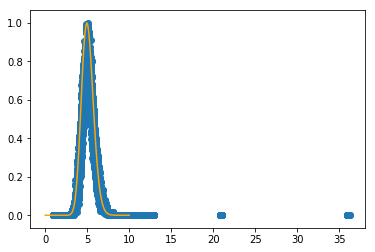

In [29]:
plt.scatter(SLinf.state['mu'],np.exp(SLinf.state['logposterior'])/np.max(np.exp(SLinf.state['logposterior'])))
plt.plot(mu_plot,gamma_posterior/np.max(gamma_posterior),color='orange')

In [30]:
np.sum(np.exp(SLinf.state['logposterior']))

310.4794760951262